# 한글설정

성공: 폰트 'Noto Sans KR'을(를) 수동으로 로드하고 기본값으로 설정했습니다.


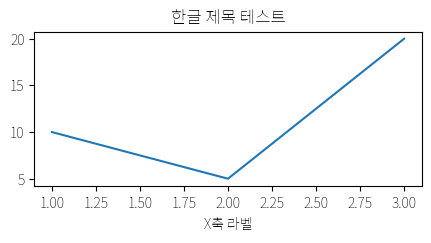

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

# 1. Windows에 설치된 폰트의 정확한 경로를 지정합니다.
# (파일이 실제 존재하는지 파일 탐색기에서 확인해 보세요)
font_location = r'C:\\Windows\\Fonts\\NotoSansKR-VF.ttf' 

# 2. 폰트 매니저에 이 폰트 파일을 수동으로 추가
try:
    fm.fontManager.addfont(font_location)
    
    # 3. 추가된 폰트 파일의 정확한 '이름'을 가져옵니다.
    font_name = fm.FontProperties(fname=font_location).get_name()
    
    # 4. matplotlib의 기본 폰트로 설정합니다.
    plt.rc('font', family=font_name)
    
    print(f"성공: 폰트 '{font_name}'을(를) 수동으로 로드하고 기본값으로 설정했습니다.")

except FileNotFoundError:
    print(f"오류: '{font_location}'에서 폰트 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"폰트 로드 중 오류 발생: {e}")

# (선택) 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# --- 테스트 플롯 ---
plt.figure(figsize=(5, 2))
plt.plot([1, 2, 3], [10, 5, 20])
plt.title('한글 제목 테스트')
plt.xlabel('X축 라벨')
plt.show()

# EDA

In [2]:
import pandas as pd
import json

# COCO JSON 파일 로드
with open(r"G:\.shortcut-targets-by-id\12b7JuoigTusx-xDcSvj9I2GRgfga508o\project1\Final_data\coco_merged.json", 'r', encoding='utf-8') as f:
    coco_data = json.load(f)


images_df = pd.DataFrame(coco_data['images'])
anns_df = pd.DataFrame(coco_data['annotations'])
cats_df = pd.DataFrame(coco_data['categories'])


cats_map = cats_df.set_index('id')['name']

# 클래스 불균형 확인


 클래스별 Annotation 개수 
name
Ginexin-F Tab-             722
Hytrin Tab- 2mg Ilyang     394
Muteran Cap- 100mg         325
Buspar Tab- 5mg Boryung    322
Gabatopa Tab- 100mg        274
                          ... 
Zoloft Tab- 100mg          112
Brintellix Tab- 20mg       112
Quetapin Tab- 25mg         112
Lexapro Tab- 15mg          112
Nexium Tab- 40mg           106
Name: count, Length: 74, dtype: int64


<Axes: title={'center': 'Class Distribution'}, xlabel='name'>

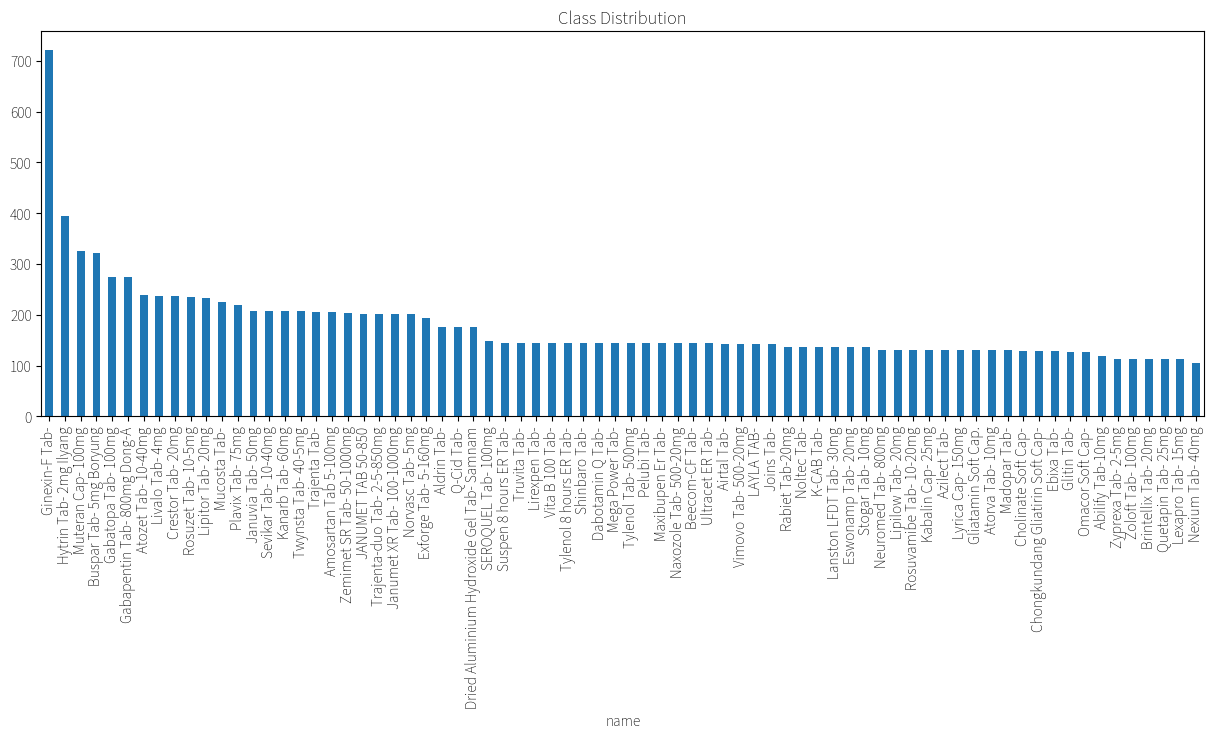

In [3]:
# 'category_id'를 기준으로 알약 이름 매핑
anns_with_names_df = anns_df.merge(cats_df, left_on='category_id', right_on='id', suffixes=('', '_cat'))

# 알약 이름별로 annotation 개수 확인
print(" 클래스별 Annotation 개수 ")
print(anns_with_names_df['name'].value_counts())

# 시각화
anns_with_names_df['name'].value_counts().plot(kind='bar', figsize=(15, 5), title="Class Distribution")

# 이미지당 객체 수 확인


이미지당 객체 수 통계 
count    1489.000000
mean        3.802552
std         0.398207
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
dtype: float64


Text(0.5, 1.0, '이미지당 객체 수')

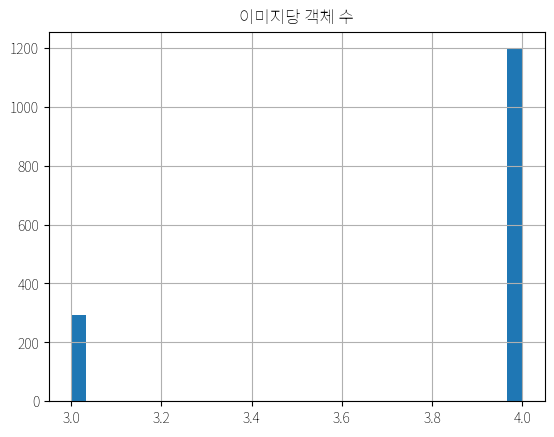

In [5]:
# 이미지 ID별 annotation 개수
anns_per_image = anns_df.groupby('image_id').size()

print("\n이미지당 객체 수 통계 ")
print(anns_per_image.describe())


# 히스토그램으로 분포 확인
ax = anns_per_image.hist(bins=30) 
ax.set_title("이미지당 객체 수")   

# 이미지 크기 분석

In [4]:
# 이미지 너비와 높이별로 그룹화
image_dims_df = images_df.groupby(['width', 'height']).size().reset_index(name='count')

print("\n이미지 크기 분포")
print(image_dims_df)




이미지 크기 분포
   width  height  count
0    976    1280   3339


# 데이터 시각화

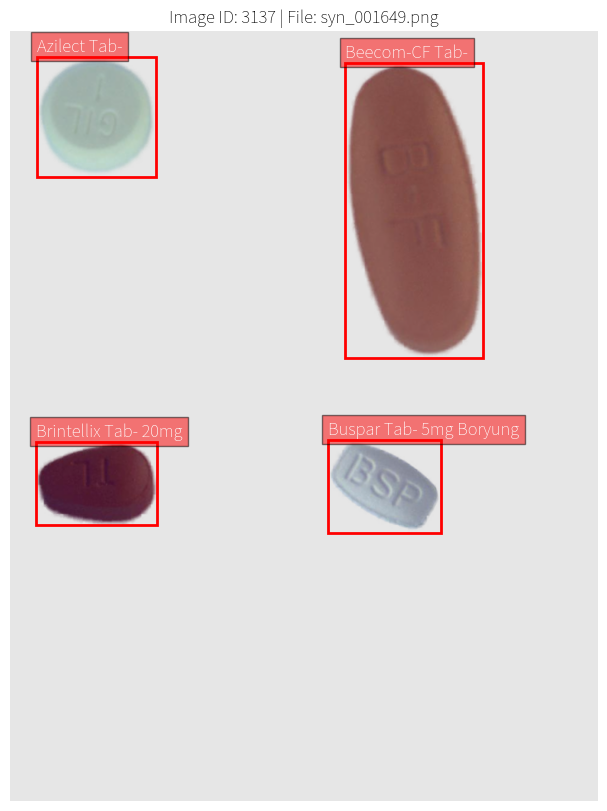

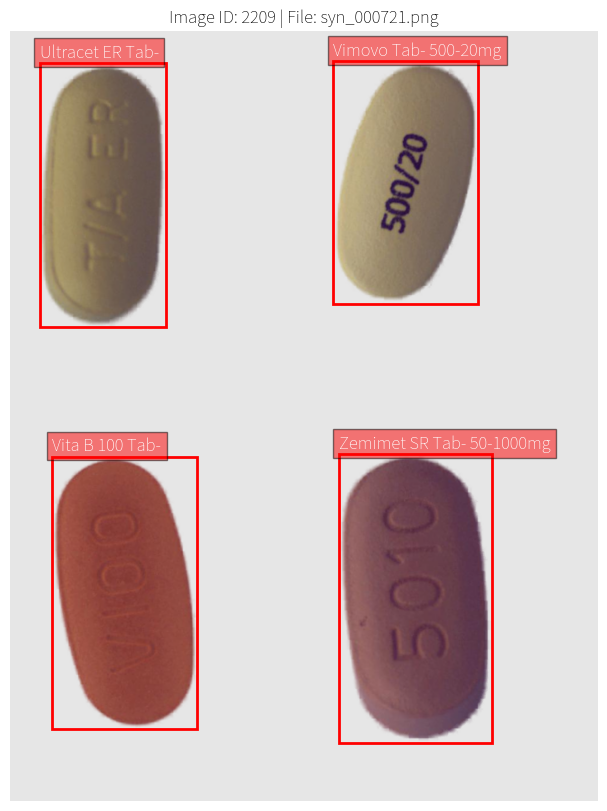

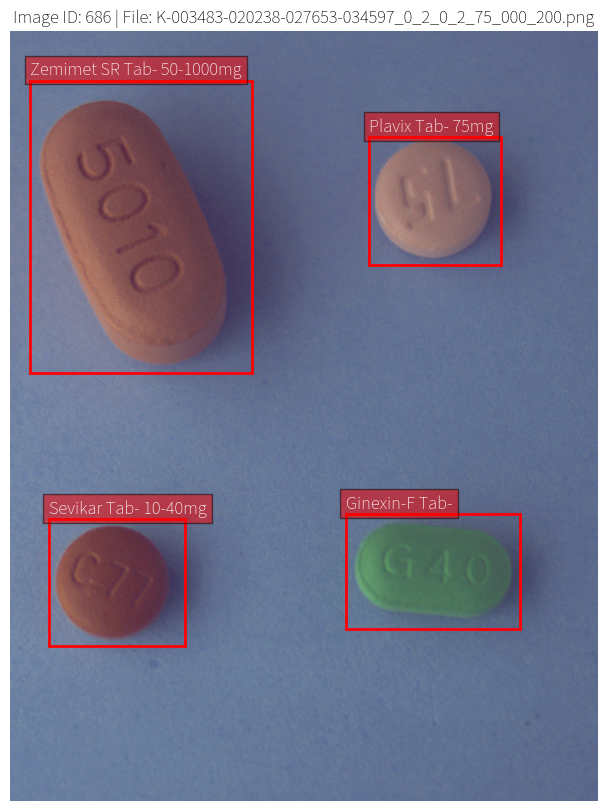

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import random

# 이미지 폴더 경로 설정
IMAGE_DIR = r"G:\.shortcut-targets-by-id\12b7JuoigTusx-xDcSvj9I2GRgfga508o\project1\Final_data\train_images" # 각자 경로에 맞게

def show_image_with_boxes(image_id):
    
    # 이미지 정보 가져옴
    image_info = images_df[images_df['id'] == image_id].iloc[0]
    image_path = os.path.join(IMAGE_DIR, image_info['file_name'])
    
    # 이미지에 해당하는 Annotation들 가져옴
    anns = anns_with_names_df[anns_with_names_df['image_id'] == image_id]
    
    # 이미지 로드
    try:
        img = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"이미지 파일을 찾을 수 없습니다. (경로 확인: {image_path})")
        return

    # 시각화
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    #  Bbox와 라벨 그리기
    for _, ann in anns.iterrows():
        bbox = ann['bbox']  # [x, y, w, h]
        class_name = ann['name']
        
        # 사각형 그리기
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 이름 텍스트 추가
        ax.text(
            bbox[0], bbox[1] - 10, # 텍스트 위치 
            class_name,
            color='white',
            fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5)
        )
        
    plt.title(f"Image ID: {image_id} | File: {image_info['file_name']}")
    plt.axis('off')
    plt.show()

# 실행
# 무작위 이미지 ID 3개 선택
random_image_ids = random.sample(list(images_df['id']), 3)

for img_id in random_image_ids:
    show_image_with_boxes(img_id)